In [1]:
#Joshua Pan AI2ES June 2021
#Use a nearby ASOS to sort images into optimal (>= 10 mi.) and suboptimal (< 10 mi.) visibility categories to create training/testing datasets
import os
import time
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import cftime
import datetime as dt
import urllib
import math
import glob
import matplotlib.image as mpimg

In [2]:
def getASOSvisseries(ASOSstn, startdate, duration, timestep, logminute = 0):
    #TODO add a minutes argument since not every station logs data on the hour
    """
    From the Iowa State Mesonet website, get the visibility in statute miles of an ASOS station for a time period. Exclusive of startdate + duration.
    
    :Parameters:
        ASOSstn (str): IATA or three-char code of ASOS station
        
        startdate (cftime or datetime object): minute = 0
        
        duration (timedelta object): how long of a time series
        
        timestep (timedelta object): sampling time step of time series
        
        logminute (int in 0..10 or 50..59): which minute of the hour does the ASOS log visibility if not on the hour?
    
    :rtype: list of timestamps (datetime object), list of visibility (floats)
    """

    #if ASOS doesn't log visibility on the hour, use a specified time up to 10 minutes away
    if logminute in range(1, 11):
        startdate += dt.timedelta(minutes = logminute)
    elif logminute in range(50, 60):
        startdate += dt.timedelta(minutes = logminute - 60)
    elif logminute != 0:
        raise ValueError('Desired ASOS measurement time must not be more than 10 minutes from the hour.')
    
    enddate = startdate + duration + dt.timedelta(days = 1)
    
    timestamps = [startdate]
    for i in range(1, duration // timestep):
        timestamps.append(timestamps[i - 1] + timestep)
    
    url = 'https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?station={}&data=vsby&year1={}&month1={}&day1={}&year2={}&month2={}&day2={}&tz=Etc%2FUTC&format=onlycomma&latlon=no&elev=no&missing=M&trace=T&direct=no&report_type=1&report_type=2'.format(ASOSstn, startdate.year, startdate.month, startdate.day, enddate.year, enddate.month, enddate.day)
    asosfile = urllib.request.urlopen(url)
    lines = asosfile.readlines()
    print(url)
    
    visibs = []
    timeidx = 0
    for idx in range(1, len(lines)):
        decoded_line = lines[idx].decode("utf-8").split(',')
        linetime = dt.datetime.strptime(decoded_line[1], '%Y-%m-%d %H:%M')
        if linetime > timestamps[-1]:
            break
        if linetime == timestamps[timeidx]: #if the line time matches the next desired time in the time series
            try:
                visibs.append(float(decoded_line[2][:-1]))
                #print(timeidx, len(visibs), timestamps[timeidx], linetime, visibs[-1])
            except ValueError: #if value is M (missing)
                visibs.append(np.nan)
            timeidx += 1
        if timeidx < len(timestamps) - 1 and linetime > timestamps[timeidx]: #if a desired time isn't available in the ASOS, skip ahead
            del(timestamps[timeidx])
            
    return timestamps, visibs

In [3]:
def imgtimeseries(startdate, hours, lists, IMGDIR = '/tf/NYSM/archive/nysm/cam_photos', xlim = (0, 1280), ylim = (0, 720)):
    """
    Puts together an hourly image-based time series by appending to lists.
    
    :Parameters:
        startdate (cftime or datetime object)
        
        hours (tuple of 2 or 3 ints): range of hours after startdate for time series to cover
        
        lists ({string: lists} or {string: tuple of lists}): the list(s) with key 'time' will contain timestamps, and the rest will contain
        the corresponding values after this procedure. Tuples of lists should be (night, day).
        
        IMGDIR (str): most specific directory with images that doesn't reference either a station or time
    """
    
    for hour in range (*hours): #hours since startdate
        date = cftime.num2date(hour, 'hours since %s' % startdate)
        if date.day == 1 and date.hour == 0:
            print('Working on date %s' % str(date))
        
        imgsubdir = '{:04d}/{:02d}/{:02d}/{}'.format(date.year, date.month, date.day, STN)

        try:
            os.chdir(os.path.join(IMGDIR, imgsubdir))
            imgfile = glob.glob('{:04d}{:02d}{:02d}T{:02d}{:02d}*'.format(date.year, date.month, date.day, date.hour, date.minute // 60 * 60))
            runappends(date, imgfile, lists, xlim, ylim)
        except:
            None

In [4]:
def runappends(date, imgfile, lists, xlim = (0, 1280), ylim = (0, 720)):
    """
    Appends the desired values for the time series.
    """
    
    try:
        #image = mpimg.imread(imgfile[0])
        lists['imgfiles'].append(imgfile[0])
        lists['time'].append(date) #be sure to put timestamps append after calls to imgfile[0] to make sure we don't save timestamps for missing images
    except:
        None

In [5]:
#read most recent camera direction for each station into a dict
CAMDIRFILE = '/tf/camdir.txt'
f = open(CAMDIRFILE, 'r')
[f.readline() for i in range(3)]

currentdirs = dict()
for line in f:
    line = line.split('|')
    stn = line[1][1:-1]
    date = line[2][1:-1]
    hdg = int(line[3][1:-3])
    currentdirs[stn] = (hdg, date)
#print(currentdirs)

2020-03-24 11:00:00 ['20200324T110028_PENN.jpg']


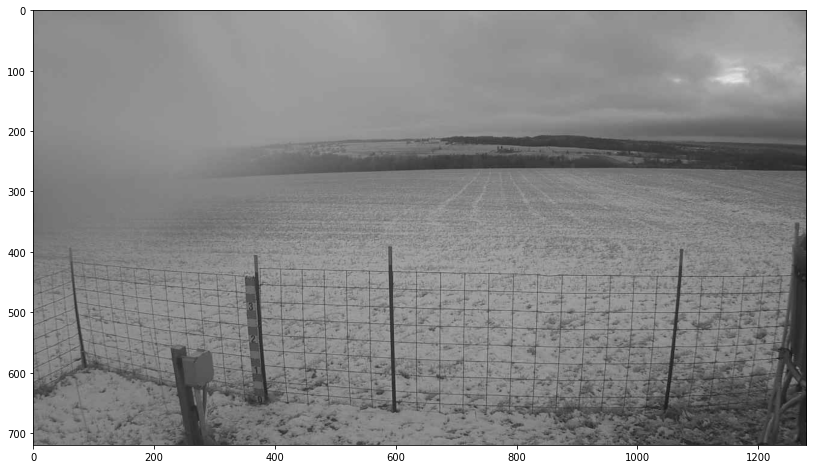

In [6]:
#open an image from a station, where the cam is facing its current direction
STN = 'PENN'
ASOS = 'PEO'
startdate = dt.datetime.strptime(currentdirs[STN][1], '%Y-%m-%d %H:%M:%S') + dt.timedelta(days=30) #skip some time to ensure cam is running
startdate = dt.datetime.strptime('2020-03-24 11:00:00', '%Y-%m-%d %H:%M:%S')
startdate -= dt.timedelta(minutes=startdate.minute)
IMGDIR = '/tf/NYSM/archive/nysm/cam_photos'
imgsubdir = '{:04d}/{:02d}/{:02d}/{}'.format(startdate.year, startdate.month, startdate.day, STN)
os.chdir(os.path.join(IMGDIR, imgsubdir))
imgfile = glob.glob('{:04d}{:02d}{:02d}T{:02d}{:02d}*'.format(startdate.year, startdate.month, startdate.day, startdate.hour, startdate.minute // 60 * 60))
print(startdate, imgfile)
image = mpimg.imread(imgfile[0])
plt.rcParams['figure.figsize'] = [20, 8]
y0 = 0
y1 = 720
x0 = 0
x1 = 1280
plt.imshow(image[y0:y1, x0:x1, :])

In [7]:
#construct image-based time series
hours = (0, int(1.25 * 365 * 24))
lists = {'time': [], 'imgfiles': []} #timestamps, image filenames
imgtimeseries(startdate, hours, lists, xlim = (x0, x1), ylim = (y0, y1))

Working on date 2020-04-01 00:00:00
Working on date 2020-05-01 00:00:00
Working on date 2020-06-01 00:00:00
Working on date 2020-07-01 00:00:00
Working on date 2020-08-01 00:00:00
Working on date 2020-09-01 00:00:00
Working on date 2020-10-01 00:00:00
Working on date 2020-11-01 00:00:00
Working on date 2020-12-01 00:00:00
Working on date 2021-01-01 00:00:00
Working on date 2021-02-01 00:00:00
Working on date 2021-03-01 00:00:00
Working on date 2021-04-01 00:00:00
Working on date 2021-05-01 00:00:00
Working on date 2021-06-01 00:00:00


In [8]:
#get ASOS visibility time series
vistimestamps, visibs = getASOSvisseries(ASOS, startdate, dt.timedelta(hours = hours[1]), dt.timedelta(hours = 1), logminute = 0)
vistimestamps = [time + dt.timedelta(minutes = 0) for time in vistimestamps]
print(len(vistimestamps), len(visibs))
print(vistimestamps[192], visibs[192])

https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?station=PEO&data=vsby&year1=2020&month1=3&day1=24&year2=2021&month2=6&day2=24&tz=Etc%2FUTC&format=onlycomma&latlon=no&elev=no&missing=M&trace=T&direct=no&report_type=1&report_type=2
9698 9698
2020-04-01 11:00:00 10.0


In [9]:
#construct a DataArray of visibility with the same timestamps as the image-based time series
arrs = {key: np.array(lists[key]) for key in lists}
visdict = {vistimestamps[i]: visibs[i] for i in range(len(visibs))}
visda = xr.DataArray(np.zeros(arrs['time'].shape), dims = ['time'], coords = [arrs['time']])
for i in range(len(visda.coords['time'].values)):
    if visda.coords['time'].values[i] in visdict:
        visda.values[i] = visdict[visda.coords['time'].values[i]]
    else:
        visda.values[i] = np.nan

In [10]:
len(arrs['time']), len(arrs['imgfiles']), len(visda.values), len(visda.coords['time'].values)

(9922, 9922, 9922, 9922)

2021-02-15 17:00:00 ['20210215T170039_PENN.jpg']
Visibility: 0.75 sm


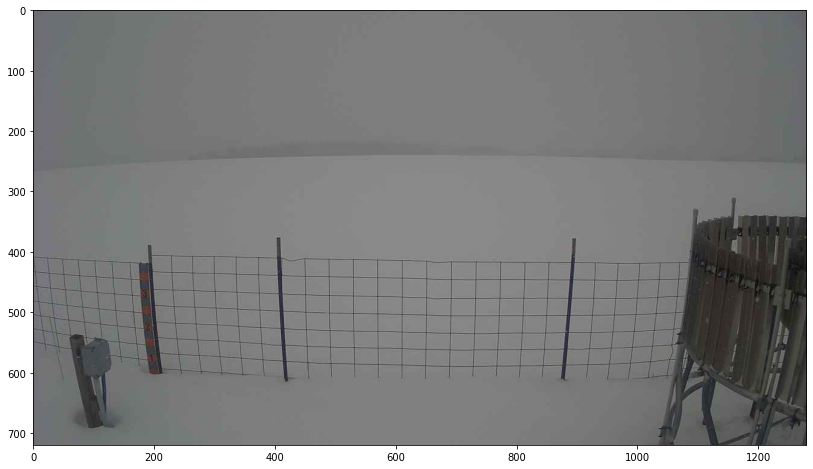

In [21]:
#visually confirm that the photo visibility matches the ASOS measurement
idxs = np.where((visda.values <= 1) & (visda.values <= 1))[0]
selidx = np.random.choice(idxs)
seldate = arrs['time'][selidx]
imgsubdir = '{:04d}/{:02d}/{:02d}/{}'.format(seldate.year, seldate.month, seldate.day, STN)
os.chdir(os.path.join(IMGDIR, imgsubdir))
imgfile = glob.glob('{:04d}{:02d}{:02d}T{:02d}{:02d}*'.format(seldate.year, seldate.month, seldate.day, seldate.hour, seldate.minute // 60 * 60))
print(seldate, imgfile)
image = mpimg.imread(imgfile[0])
print("Visibility: {:.02f} sm".format(visda.values[selidx]))
plt.imshow(image)

In [48]:
%%time
#copy images into folders by ASOS vis
idxs = np.where((visda.values >= 10) & (visda.values >= 10))[0]
for idx in idxs:
    seldate = arrs['time'][idx]
    if seldate.day == 1 and seldate.hour == 0:
            print('Working on date %s' % str(seldate))
    #print(seldate, "Visibility: {:.02f} sm".format(visda.values[idx]))
    imgsubdir = '{:04d}/{:02d}/{:02d}/{}'.format(seldate.year, seldate.month, seldate.day, STN)
    os.chdir(os.path.join(IMGDIR, imgsubdir))
    imgfile = glob.glob('{:04d}{:02d}{:02d}T{:02d}{:02d}*'.format(seldate.year, seldate.month, seldate.day, seldate.hour, seldate.minute // 60 * 60))
    try:
        os.system('cp %s /tf/visibility/model_img/%s/4' % (imgfile[0], '0721_DS2'))
    except:
        None

Working on date 2020-04-01 00:00:00
Working on date 2020-06-01 00:00:00
Working on date 2020-07-01 00:00:00
Working on date 2020-08-01 00:00:00
Working on date 2020-09-01 00:00:00
Working on date 2020-10-01 00:00:00
Working on date 2020-11-01 00:00:00
Working on date 2020-12-01 00:00:00
Working on date 2021-02-01 00:00:00
Working on date 2021-03-01 00:00:00
Working on date 2021-04-01 00:00:00
Working on date 2021-05-01 00:00:00
Working on date 2021-06-01 00:00:00
CPU times: user 6.58 s, sys: 27.3 s, total: 33.9 s
Wall time: 1min 21s
